# Practica final flujos de datos

# Introducción

En esta práctica trabajaremos con distintas fuentes de datos de carácter socioeconómico, principalmente relacionados con el empleo, los salarios y el mercado inmobiliario. Aunque los conjuntos utilizados provienen de archivos CSV estáticos, puede imaginarse fácilmente un escenario real en el que estos datos lleguen de manera continua en forma de flujo. Por ejemplo, los registros de empleo y salarios podrían obtenerse en tiempo real a partir de una API que recoja ofertas publicadas en portales como Indeed o InfoJobs, mientras que los valores de viviendas podrían provenir de servicios de inmobiliarias que actualizan sus precios constantemente. De este modo, el uso de clasificadores y modelos incrementales sobre los datos simulados nos permite aproximarnos a un contexto más realista, donde las decisiones deben adaptarse dinámicamente a información que evoluciona con el tiempo.

In [1]:
!pip install river

# Imports

In [3]:
import time
import pandas as pd
from river import stream, tree, metrics, evaluate, drift, naive_bayes,preprocessing,ensemble
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from river import datasets
from river import tree
from river import metrics
from river import evaluate, stream
import os
from river import feature_selection
from river import preprocessing
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import random
from river import forest
from river import ensemble
from river import linear_model
from river import feature_selection
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.datasets import fetch_california_housing
from river.feature_extraction import TFIDF 
from river.naive_bayes import MultinomialNB

In [3]:
random.seed(42)

# 1.Clasificación
Para nuestro problema de clasificación hemos escogido el conjunto de datos Adult del UCI Machine Learning Repository, el cual recoge información demográfica y laboral de personas (edad, nivel educativo, tipo de empleo, horas de trabajo, etc.) junto con una etiqueta binaria que indica si sus ingresos anuales superan los 50 000 USD.


# Objetivo
Aunque se trata de un dataset estático, presenta varias características que lo hacen ideal para simular un flujo de datos:

Naturaleza temporal implícita: los registros reflejan una realidad socioeconómica que, en la práctica, puede evolucionar a lo largo del tiempo.

Tamaño moderado pero suficiente: permite iterar muchas instancias de forma eficiente, como si fueran llegadas sucesivas de información de nuevos individuos.

Problema de clasificación binaria realista: predecir si una persona supera un umbral de ingresos es un caso de uso frecuente en sistemas de recomendación de créditos, análisis de riesgo o planificación social.

El objetivo de esta parte de nuestro trabajo consiste en replicar condiciones cercanas a un sistema en producción que recibe datos demográficos en tiempo real, facilitando la transición a un entorno real de big data.

### 1.1 Carga del csv y vista preliminar

In [4]:
csv_file = "data/adult.csv"

# Carga inicial solo para inspección
df = pd.read_csv(csv_file)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


### 1.2 Simular flujo de datos:

Transformamos el CSV en un generador que emite cada fila como un registro de flujo.
La columna `income` se convierte a binaria (1 si >50K, 0 en caso contrario).

In [5]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={
        "income": lambda x: 1 if ">50K" in str(x) else 0
    }
)

# Desarrollo

### 1.3 Función para elegir el modelo

In [6]:
def elegir_modelo(nombre_modelo: str):
    nombre = nombre_modelo.lower()
    if nombre == "hdt":
        return tree.HoeffdingTreeClassifier()
    elif nombre == "hat":
        return tree.HoeffdingAdaptiveTreeClassifier() # rolling para ver el accuracy en las últimas n instancias
    elif nombre == "efdt":
        return tree.ExtremelyFastDecisionTreeClassifier()
    else:
        raise ValueError("Modelo no reconocido. Usa: 'HDT', 'HAT' o 'EFDT'.")

### 1.4 Función para elegir el detector de drift

In [7]:
def elegir_detector(nombre: str):
    if nombre == "DDM":
        return drift.binary.DDM()
    elif nombre == "ADWIN":
        return drift.ADWIN()
    elif nombre == "HDDM_W":
        return drift.binary.HDDM_W()
    elif nombre == "HDDM_A":
        return drift.binary.HDDM_A()
    elif nombre == "KSWIN":
        return drift.KSWIN(alpha=0.01, window_size=200, stat_size=50) #AJUSTABLE
    elif nombre =="PH":
       return drift.PageHinkley()
    else:
        raise ValueError(
            "Detector no reconocido. Usa: 'DDM', 'ADWIN', 'HDDM_W', 'KSWIN' o 'PH'."
        )


### 1.5 Evaluación con evaluación progresiva

`evaluate.progressive_val_score` realiza el ciclo test-then-train automáticamente:
1. Predice la instancia entrante.
2. Actualiza la métrica.
3. Entrena el modelo.

In [8]:
def evaluar_modelo(data, modelo_nombre):
    modelo = elegir_modelo(modelo_nombre)
    metricas = metrics.Accuracy()
    print(f"*** Evaluación con modelo: {modelo_nombre.upper()} ***\n")
    resultado = evaluate.progressive_val_score(
        dataset=data,
        model=modelo,
        metric=metricas,
        print_every=1000  # imprime cada 1000 instancias
    )
    print(f"Accuracy final: {resultado.get():.4f}")
    return resultado.get()

### 1.6 Evaluación con detección de drift

Cuando se detecta un drift, el modelo entrenado con datos anteriores deja de representar la realidad actual, por lo que en el código reinicio el modelo cada vez que detecta un concept drift. Es cierto que, justo después de reiniciarlo, el modelo tiene pocos ejemplos y su rendimiento baja. Pero este tiempo de bajo rendimiento es preferible a mantener un modelo que predice sistemáticamente mal debido a un cambio de distribución y en el contexto de nuestro sistema no necesitamos tener un modelo preparado en todo momento, sino que es preferible asegurarnos un mejor modelo a la larga. Más adelante, con el uso de ensembles este problema se solucionaría.

In [9]:
def evaluar_modelo_con_drift(data_stream, modelo_nombre, detector_nombre, delay):

    modelo = elegir_modelo(modelo_nombre)
    detector = elegir_detector(detector_nombre)

    acc = metrics.Accuracy()

    print(f"*** Evaluación con modelo {modelo_nombre.upper()} "
          f"y detector {detector_nombre.upper()} ***\n")

    for i, (X, y) in enumerate(data_stream, start=1):
        
        y_pred = modelo.predict_one(X)
        
        acc.update(y, y_pred)

        # Actualizar detector con error (1 si fallo, 0 si acierto)
        detector.update(int(y_pred != y))

        if detector.drift_detected:
            print(f"[Drift detectado en instancia {i}] "
                    f"Accuracy acumulada antes de reinicio: {acc.get():.4f}")
            # Reiniciar modelo y detector
            modelo = elegir_modelo(modelo_nombre)
            detector = elegir_detector(detector_nombre)

        modelo.learn_one(X, y)

        if i % 1000 == 0:
            print(f"Instancia {i} | Accuracy: {acc.get():.4f}")

        if delay > 0:
            time.sleep(delay)

    print(f"\nAccuracy final: {acc.get():.4f}")
    return acc.get()


### 1.7 Evaluación con HDT

In [10]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)
evaluar_modelo(data_stream, modelo_nombre="HDT")

*** Evaluación con modelo: HDT ***

[1,000] Accuracy: 89.89%
[2,000] Accuracy: 91.60%
[3,000] Accuracy: 91.93%
[4,000] Accuracy: 91.65%
[5,000] Accuracy: 89.88%
[6,000] Accuracy: 88.16%
[7,000] Accuracy: 87.04%
[8,000] Accuracy: 86.37%
[9,000] Accuracy: 85.62%
[10,000] Accuracy: 84.68%
[11,000] Accuracy: 84.42%
[12,000] Accuracy: 84.18%
[13,000] Accuracy: 83.87%
[14,000] Accuracy: 83.53%
[15,000] Accuracy: 83.38%
[16,000] Accuracy: 83.27%
[17,000] Accuracy: 83.26%
[18,000] Accuracy: 82.95%
[19,000] Accuracy: 82.66%
[20,000] Accuracy: 82.58%
[21,000] Accuracy: 82.60%
[22,000] Accuracy: 82.62%
[23,000] Accuracy: 82.49%
[24,000] Accuracy: 82.42%
[25,000] Accuracy: 82.31%
[26,000] Accuracy: 82.21%
[27,000] Accuracy: 82.13%
[28,000] Accuracy: 82.11%
[29,000] Accuracy: 82.09%
[30,000] Accuracy: 82.06%
[31,000] Accuracy: 82.05%
[32,000] Accuracy: 81.95%
[32,561] Accuracy: 81.94%
Accuracy final: 0.8194


0.8194103194103194

Se obtiene un Accuracy =~ 0.82 sin detección de drift.

### 1.8 Evaluación HAT

In [11]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)
evaluar_modelo(data_stream, modelo_nombre="HAT")

*** Evaluación con modelo: HAT ***

[1,000] Accuracy: 83.48%
[2,000] Accuracy: 87.89%
[3,000] Accuracy: 89.46%
[4,000] Accuracy: 86.12%
[5,000] Accuracy: 77.74%
[6,000] Accuracy: 68.29%
[7,000] Accuracy: 64.49%
[8,000] Accuracy: 66.65%
[9,000] Accuracy: 68.26%
[10,000] Accuracy: 68.77%
[11,000] Accuracy: 69.99%
[12,000] Accuracy: 70.88%
[13,000] Accuracy: 71.67%
[14,000] Accuracy: 72.19%
[15,000] Accuracy: 72.73%
[16,000] Accuracy: 73.22%
[17,000] Accuracy: 73.75%
[18,000] Accuracy: 73.96%
[19,000] Accuracy: 74.31%
[20,000] Accuracy: 74.61%
[21,000] Accuracy: 74.96%
[22,000] Accuracy: 75.16%
[23,000] Accuracy: 75.32%
[24,000] Accuracy: 75.53%
[25,000] Accuracy: 75.74%
[26,000] Accuracy: 75.86%
[27,000] Accuracy: 75.93%
[28,000] Accuracy: 76.02%
[29,000] Accuracy: 76.18%
[30,000] Accuracy: 76.28%
[31,000] Accuracy: 76.40%
[32,000] Accuracy: 76.40%
[32,561] Accuracy: 76.43%
Accuracy final: 0.7643


0.7642813267813268

El rendimiento de Hoeffding Adaptive Tree (HAT) =~ 0.79 empeora ligeramente respecto a HDT, esto podría deberse a su mecanismo de detección de drift y adaptación que introduce complejidad y posibles reseteos innecesarios.

### 1.9 Evaluación HDT con detección de drift

Como HDT no es adaptativo requiere el uso de detectores de concept drift para reiniciarse en caso de que exista.

He utilizado para este caso 'DDM', 'ADWIN', 'HDDM_W'.
DDM por ser simple al estar basado en la probabilidad de error.
ADWIN al utilizar una ventana deslizante detecta tanto cambios bruscos como graduales.
Y HDDM_W por ser más ligero y eficiente que ADWIN pero más robusto que DDM.


In [12]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)
evaluar_modelo_con_drift(data_stream, modelo_nombre="HDT", detector_nombre='DDM', delay=0.0)


*** Evaluación con modelo HDT y detector DDM ***

[Drift detectado en instancia 148] Accuracy acumulada antes de reinicio: 0.7162
[Drift detectado en instancia 192] Accuracy acumulada antes de reinicio: 0.6875
[Drift detectado en instancia 357] Accuracy acumulada antes de reinicio: 0.7591
[Drift detectado en instancia 517] Accuracy acumulada antes de reinicio: 0.8317
[Drift detectado en instancia 908] Accuracy acumulada antes de reinicio: 0.8535
[Drift detectado en instancia 959] Accuracy acumulada antes de reinicio: 0.8561
[Drift detectado en instancia 993] Accuracy acumulada antes de reinicio: 0.8580
Instancia 1000 | Accuracy: 0.8590
[Drift detectado en instancia 1342] Accuracy acumulada antes de reinicio: 0.8905
[Drift detectado en instancia 1380] Accuracy acumulada antes de reinicio: 0.8899
[Drift detectado en instancia 1536] Accuracy acumulada antes de reinicio: 0.8652
[Drift detectado en instancia 1679] Accuracy acumulada antes de reinicio: 0.8761
Instancia 2000 | Accuracy: 0.891

0.8187094990940081

In [13]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)
evaluar_modelo_con_drift(data_stream, modelo_nombre="HDT", detector_nombre='ADWIN', delay=0.0)

*** Evaluación con modelo HDT y detector ADWIN ***

[Drift detectado en instancia 352] Accuracy acumulada antes de reinicio: 0.7642
[Drift detectado en instancia 576] Accuracy acumulada antes de reinicio: 0.8160
[Drift detectado en instancia 928] Accuracy acumulada antes de reinicio: 0.8394
Instancia 1000 | Accuracy: 0.8310
[Drift detectado en instancia 1120] Accuracy acumulada antes de reinicio: 0.8143


[Drift detectado en instancia 1408] Accuracy acumulada antes de reinicio: 0.8317
[Drift detectado en instancia 1568] Accuracy acumulada antes de reinicio: 0.8061
Instancia 2000 | Accuracy: 0.8435
[Drift detectado en instancia 2944] Accuracy acumulada antes de reinicio: 0.8808
Instancia 3000 | Accuracy: 0.8760
[Drift detectado en instancia 3136] Accuracy acumulada antes de reinicio: 0.8629
[Drift detectado en instancia 3328] Accuracy acumulada antes de reinicio: 0.8486
[Drift detectado en instancia 3552] Accuracy acumulada antes de reinicio: 0.8525
Instancia 4000 | Accuracy: 0.8600
[Drift detectado en instancia 4896] Accuracy acumulada antes de reinicio: 0.8552
Instancia 5000 | Accuracy: 0.8536
Instancia 6000 | Accuracy: 0.8440
Instancia 7000 | Accuracy: 0.8381
Instancia 8000 | Accuracy: 0.8363
Instancia 9000 | Accuracy: 0.8337
Instancia 10000 | Accuracy: 0.8308
Instancia 11000 | Accuracy: 0.8293
Instancia 12000 | Accuracy: 0.8277
Instancia 13000 | Accuracy: 0.8268
Instancia 14000 | Acc

0.8246675470655078

In [14]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)
evaluar_modelo_con_drift(data_stream, modelo_nombre="HDT", detector_nombre='HDDM_W', delay=0.0)

*** Evaluación con modelo HDT y detector HDDM_W ***

[Drift detectado en instancia 144] Accuracy acumulada antes de reinicio: 0.7361
Instancia 1000 | Accuracy: 0.9110
[Drift detectado en instancia 1421] Accuracy acumulada antes de reinicio: 0.9113
[Drift detectado en instancia 1534] Accuracy acumulada antes de reinicio: 0.8983
Instancia 2000 | Accuracy: 0.9175
[Drift detectado en instancia 2929] Accuracy acumulada antes de reinicio: 0.9358
Instancia 3000 | Accuracy: 0.9297
[Drift detectado en instancia 3111] Accuracy acumulada antes de reinicio: 0.9196
[Drift detectado en instancia 3198] Accuracy acumulada antes de reinicio: 0.9174
[Drift detectado en instancia 3309] Accuracy acumulada antes de reinicio: 0.9066
[Drift detectado en instancia 3380] Accuracy acumulada antes de reinicio: 0.8982
[Drift detectado en instancia 3768] Accuracy acumulada antes de reinicio: 0.9026
Instancia 4000 | Accuracy: 0.9083
[Drift detectado en instancia 4238] Accuracy acumulada antes de reinicio: 0.9132
In

0.8179724209944412

Aunque observamos que detecta muchas veces drift, sobre todo en las primeras instancias y vemos que mejora tras reiniciar el modelo, hacia el final del dataset deja de haber esa variabilidad en el concepto y el accuracy final acaba siendo practicamente igual al obtenido sin detección de drift.

### 1.10 Evaluación de HAT con detección de drift

HAT incorpora su propio ADWIN interno para sustituir ramas cuando detecta cambios locales. Estas adaptaciones generan variaciones en la secuencia de errores que hacen que salte el detector externo, produciendo más alertas de drift, incluso sin cambios reales en la distribución. Por lo que no tiene mucho sentido utilizar un detecor externo basado en el error como DDM con HAT.

En este caso concreto conviene emplear KSWIN con parámetros más permisivos porque Hoeffding Adaptive Tree (HAT) ya incorpora su propio mecanismo de adaptación al concepto mediante ADWIN en las hojas. Esto significa que el modelo se reajusta de forma interna cuando detecta variaciones, sin necesidad de un detector externo muy sensible. Si KSWIN fuera demasiado estricto, podría disparar falsas alarmas ante simples fluctuaciones, provocando reacciones innecesarias sobre un clasificador que ya se está ajustando. Al configurarlo de forma más permisiva (aumentando window_size y reduciendo alpha) KSWIN se limita a señalar únicamente cambios realmente sustanciales en lugar de duplicar o entorpecer, la capacidad adaptativa que ya tiene HAT.

In [15]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)

modelo = elegir_modelo("HAT")
detector = drift.KSWIN(alpha=0.0005, window_size=1000, stat_size=200)

acc = metrics.Accuracy()

for i, (X, y) in enumerate(data_stream, start=1):
    
    y_pred = modelo.predict_one(X)
    
    acc.update(y, y_pred)

    detector.update(int(y_pred != y))

    if detector.drift_detected:
        print(f"[Drift detectado en instancia {i}] "
                f"Accuracy acumulada antes de reinicio: {acc.get():.4f}")
        modelo = elegir_modelo("HAT")
        detector = drift.KSWIN(alpha=0.0005, window_size=1000, stat_size=200)

    modelo.learn_one(X, y)

    if i % 1000 == 0:
        print(f"Instancia {i} | Accuracy: {acc.get():.4f}")

print(f"\nAccuracy final: {acc.get():.4f}")



Instancia 1000 | Accuracy: 0.8400
[Drift detectado en instancia 1009] Accuracy acumulada antes de reinicio: 0.8414
Instancia 2000 | Accuracy: 0.8750
[Drift detectado en instancia 2968] Accuracy acumulada antes de reinicio: 0.8969
Instancia 3000 | Accuracy: 0.8937
Instancia 4000 | Accuracy: 0.8710
[Drift detectado en instancia 4083] Accuracy acumulada antes de reinicio: 0.8719
Instancia 5000 | Accuracy: 0.8664
Instancia 6000 | Accuracy: 0.8547
Instancia 7000 | Accuracy: 0.8469
[Drift detectado en instancia 7272] Accuracy acumulada antes de reinicio: 0.8405
Instancia 8000 | Accuracy: 0.8394
Instancia 9000 | Accuracy: 0.8367
Instancia 10000 | Accuracy: 0.8332
Instancia 11000 | Accuracy: 0.8316
Instancia 12000 | Accuracy: 0.8285
[Drift detectado en instancia 12016] Accuracy acumulada antes de reinicio: 0.8276
Instancia 13000 | Accuracy: 0.8267
Instancia 14000 | Accuracy: 0.8249
Instancia 15000 | Accuracy: 0.8234
[Drift detectado en instancia 15802] Accuracy acumulada antes de reinicio: 0.8

### 1.11 Data drift

En este apartado hemos decidido aplicar un detector de data drift al atributo `hours-per-week` de esta forma, en un caso real podríamos ver si la distribución de las horas trabajadas por semana cambia significativamente a lo largo del tiempo, por ejemplo por una posible reducción de jornada o un aumento de la productividad en el mercado laboral.

In [16]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={
        "income": lambda x: 1 if ">50K" in str(x) else 0,
        "hours.per.week": float    
    }
)

kswin = drift.KSWIN(alpha=0.015, window_size=500, stat_size=30)

for i, (X, y) in enumerate(data_stream, start=1):
    hours_val = float(X["hours.per.week"])

    kswin.update(hours_val)
    # Comprobamos si se detecta drift
    if kswin.drift_detected:
        print(f"[Drift detectado] Instancia {i} | hours-per-week = {hours_val}")
        kswin = drift.KSWIN(alpha=0.015, window_size=500, stat_size=30)



[Drift detectado] Instancia 500 | hours-per-week = 40.0
[Drift detectado] Instancia 1025 | hours-per-week = 40.0
[Drift detectado] Instancia 1546 | hours-per-week = 50.0
[Drift detectado] Instancia 2144 | hours-per-week = 45.0
[Drift detectado] Instancia 2895 | hours-per-week = 45.0
[Drift detectado] Instancia 3740 | hours-per-week = 40.0
[Drift detectado] Instancia 4285 | hours-per-week = 40.0
[Drift detectado] Instancia 5574 | hours-per-week = 30.0
[Drift detectado] Instancia 7359 | hours-per-week = 40.0
[Drift detectado] Instancia 10298 | hours-per-week = 60.0
[Drift detectado] Instancia 11006 | hours-per-week = 40.0
[Drift detectado] Instancia 11611 | hours-per-week = 40.0
[Drift detectado] Instancia 14745 | hours-per-week = 20.0
[Drift detectado] Instancia 16143 | hours-per-week = 40.0
[Drift detectado] Instancia 17942 | hours-per-week = 40.0
[Drift detectado] Instancia 19999 | hours-per-week = 37.0
[Drift detectado] Instancia 20636 | hours-per-week = 40.0
[Drift detectado] Instan

### 1.12 Ensembles

En este punto tiene sentido probar algún ensemble, en concreto ADWINBaggingClassifier porque combina, en un único algoritmo, dos de las ideas clave que hemos tratado: arboles incrementales y detección automática de concept drift. Este modelo mantiene un conjunto de HDTs que aprenden de manera online y, al mismo tiempo, incorpora ADWIN como detector interno de cambios. ADWIN monitoriza la secuencia de errores de cada árbol y, cuando detecta que la distribución de esos errores ha variado significativamente, asume que el concepto ha cambiado y reemplaza el solo el árbol afectado por uno nuevo. Así, el clasificador se adapta de forma continua a posibles variaciones en los datos del flujo sin que tengamos que reiniciar manualmente el entrenamiento ni decidir cuándo ocurren los cambios. Esto lo convierte en una opción muy adecuada para escenarios en los que esperamos concept drift.

Como ya hemos concluído antes, el conjunto de datos utilizado no presenta un drift muy acusado por lo que la aplicación de este tipo de modelos podría estar "sobreactuando" y aumentando la complijidad de un problema más o menos estable, lo que podría explicar la ligera bajada de rendimiento frente a modelos sencillos.

In [17]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)

model = ensemble.ADWINBaggingClassifier(
    model=tree.HoeffdingTreeClassifier(),
    n_models=5,    
    seed=42
)

metric = metrics.Accuracy()

print("*** Evaluación ADWIN BaggingClassifier ***\n")

accuracy_final = evaluate.progressive_val_score(
    dataset=data_stream,
    model=model,
    metric=metric,
    print_every=1000
)
print(f"\nAccuracy final: {metric.get():.4f}")


*** Evaluación ADWIN BaggingClassifier ***

[1,000] Accuracy: 70.97%
[2,000] Accuracy: 75.59%
[3,000] Accuracy: 81.26%
[4,000] Accuracy: 83.95%
[5,000] Accuracy: 81.92%
[6,000] Accuracy: 81.53%
[7,000] Accuracy: 81.40%
[8,000] Accuracy: 79.41%
[9,000] Accuracy: 79.66%
[10,000] Accuracy: 79.73%
[11,000] Accuracy: 79.91%
[12,000] Accuracy: 79.98%
[13,000] Accuracy: 80.06%
[14,000] Accuracy: 79.86%
[15,000] Accuracy: 79.35%
[16,000] Accuracy: 79.00%
[17,000] Accuracy: 79.16%
[18,000] Accuracy: 79.13%
[19,000] Accuracy: 79.16%
[20,000] Accuracy: 78.93%
[21,000] Accuracy: 78.62%
[22,000] Accuracy: 78.48%
[23,000] Accuracy: 78.13%
[24,000] Accuracy: 77.80%
[25,000] Accuracy: 77.84%
[26,000] Accuracy: 77.83%
[27,000] Accuracy: 77.84%
[28,000] Accuracy: 77.89%
[29,000] Accuracy: 77.98%
[30,000] Accuracy: 77.89%
[31,000] Accuracy: 77.81%
[32,000] Accuracy: 77.39%
[32,561] Accuracy: 76.73%

Accuracy final: 0.7673


### 1.13 Conclusiones

En esta sección de la práctica se ha demostrado la viabilidad de modelos de clasificación incremental para el problema de predicción de ingresos en el conjunto de datos utilizado, tratándolo como un flujo de datos continuo.


Hoeffding Tree (HDT) ofreció un rendimiento sólido y estable.

Hoeffding Adaptive Tree (HAT), diseñado para adaptarse a concept drift, no superó necesariamente a HDT en este conjunto. Esto nos sugiere que el dataset no presenta un concept drift claro.

Detección de concept drift

Se probaron detectores como DDM, ADWIN y KSWIN.

Para HAT, que ya incorpora adaptación interna, utilizamos KSWIN con parámetros más permisivos para monitorizar el flujo sin reinicios demasiado frecuentes, complementando la capacidad adaptativa del modelo sin interferir en exceso, esta aproximación demostró mejores resultados que aplicando el mismo reseteo que a un HDT.

Deteccion de Data Drift 

La monitorización de la variable específica `hours-per-week` , evidenció que la distribución de ciertas características puede variar en el tiempo, en este caso por una posible nueva ley de reducción de jornada o por un aumento de la productividad en el mercado laboral.

La prueba realizada con ensembles incrementales, concretamente con ADWINBaggingClassifier, muestra que en flujos de datos como el utilizado en este trabajo, donde la distribución de los datos es relativamente estacionaria, el coste de mantener varios modelos y reiniciarlos cuando ADWIN detecta cambios puede traducirse en una ligera pérdida de precisión frente a un único Hoeffding Tree. En otras palabras, la ventaja de los ensembles no radica en mejorar la exactitud en problemas ligeramente estáticos, sino en ofrecer robustez y resiliencia cuando las condiciones cambian realmente. En escenarios más dinámicos o sujetos a variaciones frecuentes, se esperaría que estos métodos superen a los modelos individuales, justificando su mayor complejidad computacional.

# 2. Regresión

Para el problema de regresión trabajamos con el conjunto de datos California Housing, que contiene información censal sobre características socioeconómicas y de viviendas en distintos distritos de California. Cada observación incluye variables como la mediana de la renta de los hogares, la edad media de las viviendas, el número de habitaciones, el número de ocupantes o la localización geográfica, y está asociada al valor medio de la vivienda en esa zona (en 100 de miles).
Aunque los datos provienen de un archivo estático, en esta práctica planteamos el problema como si las observaciones llegaran de forma secuencial en un flujo de datos. De esta forma, simulamos un escenario realista en el que la información sobre el mercado inmobiliario se actualiza continuamente (por ejemplo, con nuevas tasaciones o registros de compraventas), lo que requiere modelos capaces de adaptarse a cambios en el tiempo.

# Objetivo
El objetivo principal es implementar un modelo de regresión incremental que prediga el valor medio de las viviendas a partir de las variables disponibles. Para ello, se entrenarán modelos capaces de actualizar sus parámetros de manera progresiva conforme llegan nuevas instancias.
Este enfoque nos permitirá analizar el comportamiento de los modelos en un entorno dinámico, evaluar su capacidad de adaptación.

### 2.1 Carga del csv y vista preliminar

In [18]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing(as_frame=True)
df = data.frame    # DataFrame con todas las columnas
print(df.shape)
print(df.head())

(20640, 9)
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


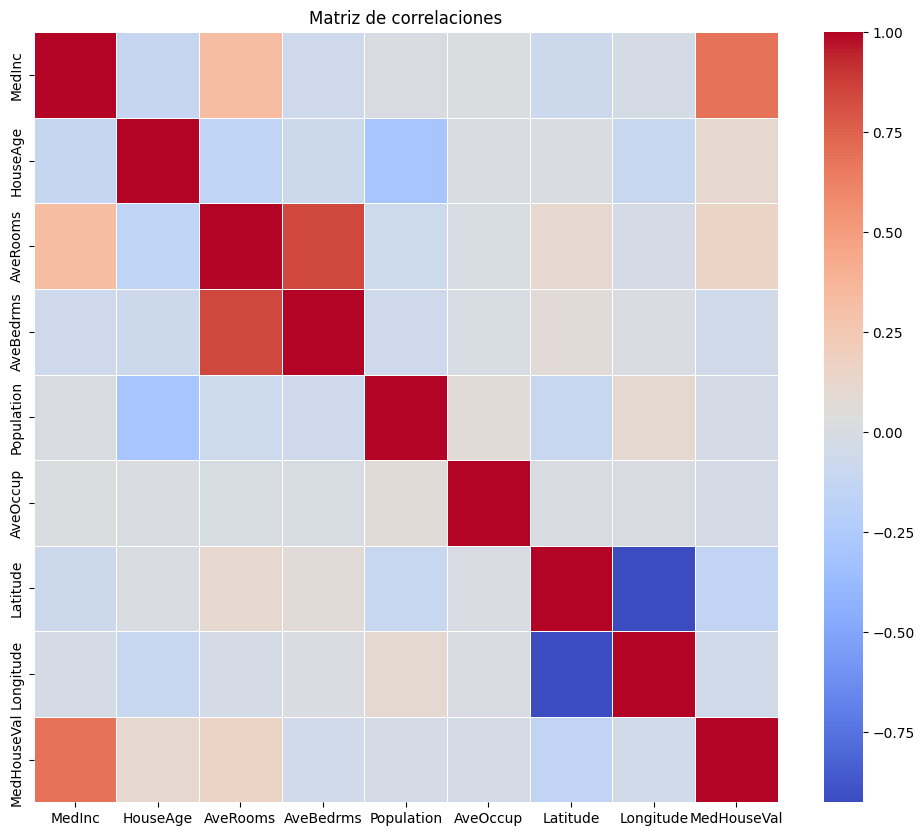

In [19]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", linewidths=.5)
plt.title("Matriz de correlaciones")
plt.show()

Vemos que hay algo de correlación, no obstante, al tratarse de flujos de datos, no podemos hacer técnicas de selección de atributos previamente por esto.

In [20]:
data_stream = ( #eliminamos la columna objetivo
    (row.drop("MedHouseVal"), row["MedHouseVal"])
    for _, row in df.iterrows() 
)

In [21]:
R2 = metrics.R2()
MAE = metrics.MAE()

Inicialmente, probamos con modelos lineales simples pero los resultados no fueron nada buenos. Para solucionarlo, incorporamos modelos más complejos como pueden ser los ensembles con arboles de decisión, que son más robustos ante problemas de multicolinealidad. Además añadimos un feature selection ya que es normal que en problemas de regresión, haya variables más utiles que otras y de esta maneraeliminamos variables innecesarias y ruído.

En cuanto a la selección de hirperparametros comentar lo siguiente:
- `grace_period` = 40, lo bajamos respecto a los 200 por defecto para favorecer las divisiones en las hojas.
- `model_selector_decay` = 0.6, ya que realmente este dataset no tiene el componente de tempralidad no habría que darle más importancia a las muestras más recientes.
- `n_models` = 4, tomamos 4 árboles para dar robustez sin añadir una complijidad excesiva. 

En cuanto al selector de características elegimos el PoissonInclusion ya que al no tener idea de cuales son los atributos más relevantes a priori, dejaremos que el atributo sea añadido con probabilidad p = 0.4

In [22]:
model = preprocessing.StandardScaler() | ensemble.BaggingRegressor(
    model=tree.HoeffdingAdaptiveTreeRegressor(grace_period=40, model_selector_decay=0.6,seed=42),
    n_models=4,
    seed=42
)
selector = feature_selection.PoissonInclusion(p=0.4, seed=42)

cont = 0
for x,y in data_stream:
    x1 = selector.transform_one(x)
    cont+=1
    y_pred = model.predict_one(x1)
    R2.update(y,y_pred)
    MAE.update(y,y_pred)
    model.learn_one(x1,y)
    if cont % 500 == 0:
        print("M1", R2)
        print("M2", MAE)

print("final", R2)
print("final", MAE)

M1 R2: 0.545666
M2 MAE: 0.425203
M1 R2: 0.592015
M2 MAE: 0.37288
M1 R2: 0.608002
M2 MAE: 0.376482
M1 R2: 0.620254
M2 MAE: 0.397364
M1 R2: 0.666302
M2 MAE: 0.379064
M1 R2: 0.701052
M2 MAE: 0.35042
M1 R2: 0.70415
M2 MAE: 0.342387
M1 R2: 0.725644
M2 MAE: 0.338386
M1 R2: 0.754647
M2 MAE: 0.351918
M1 R2: 0.738301
M2 MAE: 0.367128
M1 R2: 0.770653
M2 MAE: 0.372108
M1 R2: 0.770302
M2 MAE: 0.375465
M1 R2: 0.770073
M2 MAE: 0.369005
M1 R2: 0.772071
M2 MAE: 0.369666
M1 R2: 0.771577
M2 MAE: 0.357295
M1 R2: 0.771551
M2 MAE: 0.347696
M1 R2: 0.764145
M2 MAE: 0.347396
M1 R2: 0.782664
M2 MAE: 0.357461
M1 R2: 0.779775
M2 MAE: 0.366316
M1 R2: 0.776775
M2 MAE: 0.3668
M1 R2: 0.772272
M2 MAE: 0.36882
M1 R2: 0.767646
M2 MAE: 0.377572
M1 R2: 0.766526
M2 MAE: 0.373598
M1 R2: 0.762397
M2 MAE: 0.375573
M1 R2: 0.759086
M2 MAE: 0.375924
M1 R2: 0.762174
M2 MAE: 0.371923
M1 R2: 0.760269
M2 MAE: 0.369377
M1 R2: 0.763435
M2 MAE: 0.365458
M1 R2: 0.761043
M2 MAE: 0.367118
M1 R2: 0.757909
M2 MAE: 0.366279
M1 R2: 0.754069


Finalmente obtenemos un R2 = 0.75 lo que nos indica que el modelo es capaz de explicar un 75% de la varianza de la variable objetivo, lo cual es un resultado aceptable.
En cuanto al MAE, obtenemos un valor de 0.37 unidades en la escala original, esto determina que el erro medio en nuestras predicciones es de esa cantidad.

### Comparación frente a un regresor por lotes

Débido a las dudas respecto a las métricas obtenidas vemos apropiado compararlas frente a un modelo regresor por lotes y ver si la diferencia es abultada.

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

data = fetch_california_housing(as_frame=True)
df = data.frame  

X = df.drop(columns=["MedHouseVal"])
y = df["MedHouseVal"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

svr_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel="rbf", C=10, epsilon=0.1))
])

svr_model.fit(X_train, y_train)

y_pred = svr_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("🔹 Resultados del modelo batch (SVR)")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")


🔹 Resultados del modelo batch (SVR)
MAE:  0.3774
RMSE: 0.5689
R²:   0.7530


Vemos que los resultados son claramente comparables, practicamente iguales, lo que nos dice que nuestro modelo incremental mantiene un buen desempeño a pesar de no conocer a priori todos los datos, además tenemos todas las ventajas de un modelo incremental como el ahorro de memoria, la capacidad de dar predicciones en tiempo real o la posibilidad de adaptarse a nuevos datos en un flujo real.

# 3. TEXT MINING

Para esta sección del trabajo, el conjunto de datos empleado es sintético, simulando un conjunto real de ofertas de trabajo. En concreto, tendrá 4 columnas, una con el título de la oferta, otra con la descripción del puesto, otra con la categoría del trabajo y otra con la fecha de publicación. Esta última columna, nos permitirá simular que estos datos conforman un flujo real, pues podemos ordenar el dataset por fecha de más antigua a más reciente, haciendo como que los datos van llegando secuencialmente.



## Objetivo

El objetivo es clasificar anuncios de puestos de trabajo en diferentes categorías (tecnologia finanzas deportes salud hosteleria derecho marketing y educacion) a partir del análisis del texto resultante de concatenar el título y la descripción. Para ello, se utilizan técnicas de preprocesamiento de texto (TFIDF) y modelos de clasificación incremental (NB-Multinomial).

### Desarrollo

In [199]:
csv = 'data/jobs2.csv'

In [200]:
df = pd.read_csv(csv, parse_dates=["fecha_publicacion"])

In [201]:
df.head()

,titulo,descripcion,categoria,fecha_publicacion
0,Gestor/a de riesgos,Controller buscado para un puesto estable en e...,finanzas,2023-06-07
1,Controller,Contable buscado para un puesto estable en el ...,finanzas,2023-08-13
2,Preparador/a físico/a,Técnico/a de rendimiento buscado para un puest...,deportes,2024-08-14
3,Preparador/a físico/a,Entrenador/a buscado para un puesto estable en...,deportes,2024-11-07
4,Especialista en marketing,Gestor de redes sociales buscado para un puest...,marketing,2024-01-01


In [202]:
df.shape

(12000, 4)

Ordenamos el dataset por fecha para poder simular que los datos han ido llegando progresivamente a través de un flujo de datos:

In [203]:
df = df.sort_values(by="fecha_publicacion", ascending=True)

In [204]:
df = df.reset_index().drop(columns=["index"])

In [205]:
df.head()

,titulo,descripcion,categoria,fecha_publicacion
0,Asesor/a fiscal,Analista financiero/a buscado para un puesto e...,finanzas,2023-01-01
1,Técnico/a de rendimiento,Preparador/a físico/a buscado para un puesto e...,deportes,2023-01-01
2,Técnico/a de rendimiento,Técnico/a de rendimiento buscado para un puest...,deportes,2023-01-01
3,Especialista en marketing,Brand manager buscado para un puesto estable e...,marketing,2023-01-01
4,Procurador/a,Secretario/a legal buscado para un puesto esta...,derecho,2023-01-01


In [206]:
df["categoria"].value_counts()

categoria
tecnologia    2100
finanzas      1900
deportes      1800
salud         1700
hosteleria    1400
derecho       1400
marketing      850
educacion      850
Name: count, dtype: int64

Juntamos todo el texto en una sola columna para ayudar a TFIDF en River

In [207]:
df["text"] = df["titulo"]+". " +df["descripcion"]

Borramos columnas innecesarias:

In [208]:
df = df.drop(columns=["descripcion", "titulo", "fecha_publicacion"])

In [209]:
data_stream = ((row.drop("categoria"), row["categoria"]) for _,row in df.iterrows())

Usaremos Naive Bayes multinomial ya que es un modelo que tradicionalmente siempre ha funcionado realmente bien en clasificación de textos. Además, previamente usamos TF-IDF porque resalta las palabras clave de un documento al dar más peso a los términos distintivos y restar importancia a los comunes, mejorando así el análisis y comparación de textos.

In [210]:
from river.compose import Pipeline
model = Pipeline(
    ("tfidf", TFIDF(on="text", lowercase=True, normalize=True)),
    ("nb", MultinomialNB()),
)
metric = metrics.Accuracy()

In [211]:
metric = metrics.Accuracy()
score = evaluate.progressive_val_score(data_stream, model, metric,print_every=500)
print(f"Prequential: Accuracy={score}")

[500] Accuracy: 91.38%
[1,000] Accuracy: 95.70%
[1,500] Accuracy: 97.13%
[2,000] Accuracy: 97.85%
[2,500] Accuracy: 98.28%
[3,000] Accuracy: 98.57%
[3,500] Accuracy: 98.77%
[4,000] Accuracy: 98.92%
[4,500] Accuracy: 99.04%
[5,000] Accuracy: 99.14%
[5,500] Accuracy: 99.22%
[6,000] Accuracy: 99.28%
[6,500] Accuracy: 99.34%
[7,000] Accuracy: 99.39%
[7,500] Accuracy: 99.43%
[8,000] Accuracy: 99.46%
[8,500] Accuracy: 99.49%
[9,000] Accuracy: 99.52%
[9,500] Accuracy: 99.55%
[10,000] Accuracy: 99.57%
[10,500] Accuracy: 99.59%
[11,000] Accuracy: 99.61%
[11,500] Accuracy: 99.63%
[12,000] Accuracy: 99.64%
Prequential: Accuracy=Accuracy: 99.64%


Vemos que los resultados son realmente buenos. Esto era esperable, ya que los conjuntos están bastante diferenciados entre sí, pero este modelo puede servir como un excelente clasificador de ofertas que vengan descategorizadas, para que en tiempo real podamos añadirle esa etiqueta de categoría y añadirla a la sección de anuncios que sea sin necesidad de intervención humana.

In [212]:
unseen = [
    {"text": "entrenamiento"},
    {"text": "sistemas"},
    {"text": "calidad"},
    {"text": "economía"},
    {"text": "red social"},
    {"text": "eventos"},
    {"text": "tutor"}
]

In [213]:
for x in unseen:
    proba = model.predict_proba_one(x)
    print(x["text"], "->", proba)

entrenamiento -> {'finanzas': 0.004986906723608677, 'deportes': 0.9652137034420056, 'marketing': 0.00494117261041397, 'derecho': 0.005036817870717097, 'hosteleria': 0.005013329103459693, 'tecnologia': 0.005040166263189864, 'educacion': 0.004853006603787572, 'salud': 0.004914897382817515}
sistemas -> {'finanzas': 0.010153548411655899, 'deportes': 0.009878248055112232, 'marketing': 0.010060431865042295, 'derecho': 0.010255169572133493, 'hosteleria': 0.010207345470200904, 'tecnologia': 0.9295573999834046, 'educacion': 0.009880922227874726, 'salud': 0.010006934414575681}
calidad -> {'finanzas': 0.005927117037855612, 'deportes': 0.005766410911520062, 'marketing': 0.00587276040827514, 'derecho': 0.005986438221667762, 'hosteleria': 0.9588473521990124, 'tecnologia': 0.0059904179059038455, 'educacion': 0.005767971955433001, 'salud': 0.005841531360331812}
economía -> {'finanzas': 0.9617767787115127, 'deportes': 0.0053518483727142754, 'marketing': 0.005450552122738502, 'derecho': 0.00555605733732

In [214]:
for x in unseen:
    proba = model.predict_proba_one(x)
    print(x["text"], "->", max(proba, key=proba.get))

entrenamiento -> deportes
sistemas -> tecnologia
calidad -> hosteleria
economía -> finanzas
red social -> marketing
eventos -> hosteleria
tutor -> educacion


Hemos visto cómo clasifica el modelo estas palabras en la categoría a la que pertenecen.

# 4. Clustering